In [370]:
import pandas as pd
import numpy as np

import re
import string

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.cluster import KMeans

In [371]:
da = pd.read_excel('Online Retail.xlsx')

In [372]:
da.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [373]:
da.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [374]:
da.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

In [375]:
da.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null datetime64[ns]
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [376]:
# Transaction Level
da.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [377]:
da.shape

(541909, 8)

## Data Cleaning

In [378]:
da['Date'] = da['InvoiceDate'].apply(lambda x : x.date())
da['Time'] = da['InvoiceDate'].apply(lambda x : x.time())
da['Amount'] = da['Quantity'] * da['UnitPrice']
da.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Date,Time,Amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01,08:26:00,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,08:26:00,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01,08:26:00,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,08:26:00,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,08:26:00,20.34


 We see that null values are present in the columns Description and CustomerID

In [379]:
da.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
Date                0
Time                0
Amount              0
dtype: int64

We also see that Quantity and Unit Price has negative values which is not possible.

In [380]:
da.nunique()

InvoiceNo      25900
StockCode       4070
Description     4223
Quantity         722
InvoiceDate    23260
UnitPrice       1630
CustomerID      4372
Country           38
Date             305
Time             774
Amount          6204
dtype: int64

### Description : Cleaning

In [381]:
#stock_desc_dict = dict(list(zip(da.StockCode, da.Description)))
stock_desc_dict = {}
for sc in da.StockCode.unique():
    desc = list(da[da['StockCode'] == sc]['Description'].unique())
    if sc in stock_desc_dict:
        for des in desc:
            if des not in stock_desc_dict[sc]:
                stock_desc_dict[sc].append(des)
    else:
        stock_desc_dict.update({sc : desc})

In [382]:
multi_values = [value for key, value in stock_desc_dict.items() if len(value) > 1]
keys_multi_values = [[key, value] for key, value in stock_desc_dict.items() if len(value) > 1]
all_multi_values = []
for value in multi_values:
    all_multi_values.extend(value)
all_multi_values = list(set(all_multi_values))

In [383]:
abnormal_description_pattern = "[a-z?]"

abnormal_description = [str(desc) for desc in list(set(list(da.Description))) if pd.isnull(desc) == False and re.search(abnormal_description_pattern, str(desc))]
normal_description = list(set(list(da.Description)).difference(set(abnormal_description)))

In [384]:
[i for i in normal_description if str(i).lower().find('amaz') != -1 or str(i).lower().find('dam') != -1 or str(i).lower().find('?') != -1]

['AMAZON', 'DAMAGED', 'AMAZON FEE']

In [385]:
#pd.Series(abnormal_description).iloc[200:]
#da[da['Description'].isin()]

actually_normal = list(set(['BAG 500g SWIRLY MARBLES', 'BAG 125g SWIRLY MARBLES', 'NUMBER TILE VINTAGE FONT No ', 
'FRENCH BLUE METAL DOOR SIGN No', 'POLYESTER FILLER PAD 30CMx30CM', 'POLYESTER FILLER PAD 40x40cm', 
'POLYESTER FILLER PAD 45x30cm', 'POLYESTER FILLER PAD 45x45cm', 'POLYESTER FILLER PAD 60x40cm', 
'POLYESTER FILLER PAD 65CMx65CM', 'ESSENTIAL BALM 3.5g TIN IN ENVELOPE', 'NUMBER TILE COTTAGE GARDEN No',
'FOLK ART GREETING CARD,pack/12', 'FLOWERS HANDBAG blue and orange',
'THE KING GIFT BAG 25x24x12cm', '3 TRADITIONAl BISCUIT CUTTERS  SET']))

In [386]:
normal_description.extend(actually_normal)
normal_description = list(set(normal_description))

In [387]:
#normal_description = list(set(normal_description.extend(actually_normal)))
abnormal_description = list(set(abnormal_description).difference(set(actually_normal)))

In [388]:
print(len(list(set(normal_description))), len(list(set(abnormal_description))))

4035 189


In [389]:
actually_abnormal = ['DAMAGED', 'AMAZON', 'AMAZON FEE']

abnormal_description.extend(actually_abnormal)
abnormal_description = list(set(abnormal_description))

In [390]:
normal_description = list(set(normal_description).difference(set(actually_abnormal)))

In [391]:
null_desc = da[da['Description'].isnull()]

### Unit Price : Cleaning

We have 2515 records with a unit price of value 0. We probe further to understand the reason for it.

In [392]:
unit_zero = da[da['UnitPrice'] == 0]

In [393]:
unit_zero.sort_values('InvoiceNo').head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Date,Time,Amount
622,536414,22139,NaN,56,2010-12-01 11:52:00,0.0,NaN,United Kingdom,2010-12-01,11:52:00,0.0
1970,536545,21134,NaN,1,2010-12-01 14:32:00,0.0,NaN,United Kingdom,2010-12-01,14:32:00,0.0
1971,536546,22145,NaN,1,2010-12-01 14:33:00,0.0,NaN,United Kingdom,2010-12-01,14:33:00,0.0
1972,536547,37509,NaN,1,2010-12-01 14:33:00,0.0,NaN,United Kingdom,2010-12-01,14:33:00,0.0
1987,536549,85226A,NaN,1,2010-12-01 14:34:00,0.0,NaN,United Kingdom,2010-12-01,14:34:00,0.0


The total number of null descriptions we observed in the dataset was 1454.\
All the 1454 null descriptions have an unit price of zero.

In [394]:
unit_zero.isnull().sum()

InvoiceNo         0
StockCode         0
Description    1454
Quantity          0
InvoiceDate       0
UnitPrice         0
CustomerID     2475
Country           0
Date              0
Time              0
Amount            0
dtype: int64

All null descriptions have Customer ID also as zero

&#8594; Thus it is good enough to omit the rest of the records with zero unit priceThis gives us enough support to omit records with unit price of value 0 which inturn also removes all null descriptions encountered in the dataset

In [395]:
unit_zero[unit_zero['Description'].isnull()]['CustomerID'].isnull().sum()

1454

Below we check if it is safe to remove the other records which has a unit price of value 0 or if it can be imputed and used in any manner

In [396]:
unit_zero['InvoiceNo'].nunique()

2155

In [397]:
unit_zero['InvoiceNo'].value_counts().head()

539856    64
537534    57
545176    49
553521    40
558340    35
Name: InvoiceNo, dtype: int64

In [398]:
unit_zero_one_invoice = unit_zero['InvoiceNo'].value_counts().reset_index().query("InvoiceNo == 1")['index'].tolist()
unit_zero_one_invoice_desc = unit_zero[unit_zero['InvoiceNo'].isin(unit_zero_one_invoice)]['Description'].unique().tolist()

In [399]:
unit_zero[unit_zero['InvoiceNo'].isin(unit_zero_one_invoice)]['Description'].value_counts().head()

check      159
?           47
damages     45
damaged     43
found       25
Name: Description, dtype: int64

In [400]:
len(list(set(unit_zero_one_invoice_desc).intersection(set(abnormal_description))))

174

From both the value_counts and the intersection with the abnormal description it is clear that there are only less valid descriptions.

In [401]:
unit_zero_cons_inv = unit_zero['InvoiceNo'].value_counts().reset_index().query("InvoiceNo > 1")['index'].tolist()

In [402]:
unit_zero_cons_inv_price = pd.DataFrame(da[da['InvoiceNo'].isin(unit_zero_cons_inv)].groupby('InvoiceNo')['UnitPrice'].value_counts())  #539856

 Certain InvoiceNo have one entry called Manual, which records the entire cost of the transaction

In [404]:
unit_zero[unit_zero['Description'] == 'Manual']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Date,Time,Amount
285657,561916,M,Manual,1,2011-08-01 11:44:00,0.0,15581.0,United Kingdom,2011-08-01,11:44:00,0.0
361825,568384,M,Manual,1,2011-09-27 09:46:00,0.0,12748.0,United Kingdom,2011-09-27,09:46:00,0.0
395529,571035,M,Manual,1,2011-10-13 12:50:00,0.0,12446.0,RSA,2011-10-13,12:50:00,0.0
436961,574252,M,Manual,1,2011-11-03 13:24:00,0.0,12437.0,France,2011-11-03,13:24:00,0.0
479546,577168,M,Manual,1,2011-11-18 10:42:00,0.0,12603.0,Germany,2011-11-18,10:42:00,0.0
485985,577696,M,Manual,1,2011-11-21 11:57:00,0.0,16406.0,United Kingdom,2011-11-21,11:57:00,0.0


In [405]:
da[da['Description'] == 'Manual'].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Date,Time,Amount
2239,536569,M,Manual,1,2010-12-01 15:35:00,1.25,16274.0,United Kingdom,2010-12-01,15:35:00,1.25
2250,536569,M,Manual,1,2010-12-01 15:35:00,18.95,16274.0,United Kingdom,2010-12-01,15:35:00,18.95
5684,536865,M,Manual,1,2010-12-03 11:28:00,2.55,NaN,United Kingdom,2010-12-03,11:28:00,2.55
6798,536981,M,Manual,2,2010-12-03 14:26:00,0.85,14723.0,United Kingdom,2010-12-03,14:26:00,1.70
7976,537077,M,Manual,12,2010-12-05 11:59:00,0.42,17062.0,United Kingdom,2010-12-05,11:59:00,5.04


In [406]:
da[(da['Description'] == 'Manual') & (da['InvoiceNo'].str.contains("^C", na = False, regex = True))].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Date,Time,Amount
14716,C537610,M,Manual,-1,2010-12-07 13:23:00,631.31,NaN,United Kingdom,2010-12-07,13:23:00,-631.31
14728,C537613,M,Manual,-1,2010-12-07 13:28:00,313.78,NaN,United Kingdom,2010-12-07,13:28:00,-313.78
21758,C538124,M,Manual,-4,2010-12-09 15:43:00,0.50,15329.0,United Kingdom,2010-12-09,15:43:00,-2.00
23241,C538189,M,Manual,-1,2010-12-10 10:35:00,133.08,NaN,United Kingdom,2010-12-10,10:35:00,-133.08
28993,C538681,M,Manual,-1,2010-12-13 17:12:00,316.30,NaN,United Kingdom,2010-12-13,17:12:00,-316.30


In [407]:
da[(da['Description'] == 'Manual')]['InvoiceNo'].nunique()

518

In [408]:
for i in unit_zero_cons_inv:
    val = str(i)
    print(unit_zero_cons_inv_price.query("InvoiceNo == @val"))

                     UnitPrice
InvoiceNo UnitPrice           
539856    0.0               64
          1298.4             1
                     UnitPrice
InvoiceNo UnitPrice           
537534    0.00              57
          924.59             1
                     UnitPrice
InvoiceNo UnitPrice           
545176    0.00              49
          764.12             1
                     UnitPrice
InvoiceNo UnitPrice           
553521    0.00              40
          452.45             1
                     UnitPrice
InvoiceNo UnitPrice           
558340    0.00              35
          481.45             1
                     UnitPrice
InvoiceNo UnitPrice           
553539    0.00              31
          465.87             1
                     UnitPrice
InvoiceNo UnitPrice           
546933    0.00              30
          498.79             1
                     UnitPrice
InvoiceNo UnitPrice           
564530    0.0               29
          312.5              1
        

This shows only 6 to 7 transactions have only 0 in Unitprice and can thus be neglected.

&#8594; Thus it is good enough to omit the rest of the records with zero unit price

### Cancelled Products 

The data description tells us that if any InvoiceNo starts with C, it means it is a cancelled transaction.

In [409]:
da.InvoiceNo = da.InvoiceNo.astype(str)
truth_values = da.InvoiceNo.str.startswith("C", na = False)
cancelled_da = da[truth_values]
cancelled_da[cancelled_da['Quantity'] < 0].shape

(9288, 11)

In [410]:
cancelled_da.shape

(9288, 11)

In [411]:
cancelled_da.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Date,Time,Amount
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom,2010-12-01,09:41:00,-27.50
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom,2010-12-01,09:49:00,-4.65
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom,2010-12-01,10:24:00,-19.80
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,2010-12-01,10:24:00,-6.96
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,2010-12-01,10:24:00,-6.96


In [412]:
cancelled_da[cancelled_da['Quantity'] < 0].shape == cancelled_da.shape
# Thus, we understand all cancelled products (starting with 'C') have a negative quantity

True

Removing those records that are justfied to remove

In [413]:
da_new = da[~da['Description'].isnull()] # removing null descriptions
print(da_new.shape)
print('No. of records removed : ', da.shape[0] - da_new.shape[0])

(540455, 11)
No. of records removed :  1454


In [414]:
print('No. of records removed : ', da_new[da_new['UnitPrice'] <= 0].shape[0]) # Removing unit price 0
da_new = da_new[da_new['UnitPrice'] > 0]
print(da_new.shape)

No. of records removed :  1063
(539392, 11)


In [415]:
da_new = da_new[~da_new.InvoiceNo.isin(cancelled_da.InvoiceNo)] # Removing cancelled items 

In [416]:
da_new.shape

(530104, 11)

In [417]:
neg_quant = da_new[da_new['Quantity'] < 0]
neg_quant

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Date,Time,Amount


This shows there is no quantity with a negative value. Hurray !!

In [418]:
da_new.loc[da_new.CustomerID.isnull(),'CustomerID'] = da_new[da.CustomerID.isnull()]['InvoiceNo'] # Replacing null cid's

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [419]:
da_new.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
Date           0
Time           0
Amount         0
dtype: int64

In [420]:
neg_quant_not_can = da[(da['Quantity'] < 0) & (~da['InvoiceNo'].isin(cancelled_da['InvoiceNo']))]
neg_quant_not_can.nunique()

InvoiceNo      1336
StockCode      1082
Description     138
Quantity        298
InvoiceDate    1114
UnitPrice         1
CustomerID        0
Country           1
Date            201
Time            483
Amount            1
dtype: int64

In [422]:
escaped_des = list(set(neg_quant_not_can['Description'].unique()).difference(set(abnormal_description)))
da[da['Description'].isin(escaped_des)].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Date,Time,Amount
622,536414,22139,NaN,56,2010-12-01 11:52:00,0.0,NaN,United Kingdom,2010-12-01,11:52:00,0.0
1970,536545,21134,NaN,1,2010-12-01 14:32:00,0.0,NaN,United Kingdom,2010-12-01,14:32:00,0.0
1971,536546,22145,NaN,1,2010-12-01 14:33:00,0.0,NaN,United Kingdom,2010-12-01,14:33:00,0.0
1972,536547,37509,NaN,1,2010-12-01 14:33:00,0.0,NaN,United Kingdom,2010-12-01,14:33:00,0.0
1987,536549,85226A,NaN,1,2010-12-01 14:34:00,0.0,NaN,United Kingdom,2010-12-01,14:34:00,0.0


In [423]:
escaped_des
# This should be added to abnormal description.
# Remaining all belong to cancelled_da

[nan,
 20713,
 'CHECK',
 'MIA',
 'WET/MOULDY',
 'MERCHANT CHANDLER CREDIT ERROR, STO']

### StockCode : Cleaning

In [424]:
ambiguous_stockcodes = list(da[da['StockCode'].str.contains("^[A-Z]+$", na = False, regex = True)]['StockCode'].unique())
ambiguous_stockcodes

['POST',
 'D',
 'DOT',
 'M',
 'S',
 'AMAZONFEE',
 'DCGSSBOY',
 'DCGSSGIRL',
 'PADS',
 'B',
 'CRUK']

In [425]:
xx = list(da[da['StockCode'].isin(ambiguous_stockcodes)]['Description'].unique())
[i for i in xx if i not in abnormal_description]

['POSTAGE',
 'DOTCOM POSTAGE',
 'SAMPLES',
 nan,
 'BOYS PARTY BAG',
 'GIRLS PARTY BAG',
 'PADS TO MATCH ALL CUSHIONS']

Needs to be aded exccept boys and girls

### CustomerID : Cleaning

In [426]:
null_cid = da_new[da_new['CustomerID'].isnull()]
null_cid

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Date,Time,Amount


In [427]:
null_cid[null_cid['Quantity'] < 0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Date,Time,Amount


In [428]:
null_cid[null_cid['UnitPrice'] <= 0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Date,Time,Amount


250g needs to be added

In [429]:
da_new[da_new['Description'].isin(abnormal_description)]['Description'].value_counts()

Manual                                 322
BAG 250g SWIRLY MARBLES                249
Next Day Carriage                       79
Bank Charges                            12
Dotcomgiftshop Gift Voucher £20.00       9
Dotcomgiftshop Gift Voucher £10.00       8
Dotcomgiftshop Gift Voucher £30.00       7
Dotcomgiftshop Gift Voucher £50.00       4
High Resolution Image                    3
Dotcomgiftshop Gift Voucher £40.00       3
Dad's Cab Electronic Meter               2
*USB Office Mirror Ball                  2
Dr. Jam's Arouzer Stress Ball            2
AMAZON FEE                               2
*Boombox Ipod Classic                    1
Dotcomgiftshop Gift Voucher £100.00      1
Adjust bad debt                          1
Name: Description, dtype: int64

In [430]:
null_cid[null_cid['Description'].isin(abnormal_description)]['Description'].value_counts()

Series([], Name: Description, dtype: int64)

In [431]:
null_cid_cons_invoice = null_cid['InvoiceNo'].value_counts().reset_index(name = 'invoice_count').query("invoice_count >= 2")
null_cid_cons_invoice

,index,invoice_count


In [432]:
da_new[da_new['InvoiceNo'].isin(null_cid_cons_invoice['index'])]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Date,Time,Amount


In [433]:
da[da['InvoiceNo'] == 573585]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Date,Time,Amount


In [435]:
#data["College"].str.lower().str.endswith(search, na = False) 
xx = da['InvoiceNo'].str.lower().str.endswith("585", na = False)
da[xx].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Date,Time,Amount
2365,536585,37449,CERAMIC CAKE STAND + HANGING CAKES,2,2010-12-01 16:24:00,9.95,17460.0,United Kingdom,2010-12-01,16:24:00,19.90
38542,539585,21009,NaN,1,2010-12-20 12:54:00,0.00,NaN,United Kingdom,2010-12-20,12:54:00,0.00
63610,541585,22167,OVAL WALL MIRROR DIAMANTE,2,2011-01-19 14:22:00,9.95,14180.0,United Kingdom,2011-01-19,14:22:00,19.90
63611,541585,84968A,SET OF 16 VINTAGE ROSE CUTLERY,1,2011-01-19 14:22:00,12.75,14180.0,United Kingdom,2011-01-19,14:22:00,12.75
63612,541585,85159B,"WHITE TEA,COFFEE,SUGAR JARS",2,2011-01-19 14:22:00,6.35,14180.0,United Kingdom,2011-01-19,14:22:00,12.70


## Customer Lifetime Value

Customer Lifetime Value (CLV) is a monetary value that represents the amount of revenue or profit a customer will give the company over the period of the relationship. 

 Focusing on the customers who have a high value of CLV would turn out to be a profitable decision for the business.

 Here we calculate the CLV of every customer associated with the business. 

In [436]:
da_new.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Date,Time,Amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,2010-12-01,08:26:00,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01,08:26:00,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,2010-12-01,08:26:00,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01,08:26:00,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01,08:26:00,20.34


### Customer Statistics

###### For every customer, the following statistics are considered :
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;num_transactions  : The total number of transactions the customer has made.\
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;total_amount          : The total amount the customer has contributed towards the business by purchasing products.\
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;quantity                  : The total quantity of items purchased by the customer.\
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;num_days             : The number of days the customer has been associated with the business

In [438]:
customer_grouped = da_new.groupby('CustomerID').aggregate({'InvoiceNo' : len,
                                                           'Amount' : sum,
                                                           'Quantity' : sum,
                                                           'Date' : lambda date : (date.max() - date.min()).days
                                                          })
customer_grouped.columns = ['num_transactions', 'total_amount', 'quantity', 'num_days']
customer_grouped.head()

,num_transactions,total_amount,quantity,num_days
CustomerID,,,,
12346.0,1,77183.60,74215,0
12347.0,182,4310.00,2458,365
12348.0,31,1797.24,2341,283
12349.0,73,1757.55,631,0
12350.0,17,334.40,197,0


###### CLV is calculated using the following formula :
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;CLTV = ((Average Order Value x Purchase Frequency) / Churn Rate) x Profit margin.\
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;Average Order Value = Total Revenue / Total Number of Orders\
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;Purchase Frequency =  Total Number of Orders / Total Number of Customers\
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;Repeat Rate = Number of customers with more than one order / Number of unique customers\
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;Churn Rate = 1 - Repeat Rate 

In [439]:
customer_grouped['AOV'] = customer_grouped['total_amount'] / customer_grouped['num_transactions']

purchase_frequency = customer_grouped['num_transactions'].sum() / customer_grouped.shape[0]
repeat_rate = customer_grouped[customer_grouped['num_transactions'] > 1].shape[0] / customer_grouped.shape[0]
churn_rate = customer_grouped[customer_grouped['num_transactions'] == 1].shape[0] / customer_grouped.shape[0] # 1 - rep.rate
customer_lifetime = 1 / churn_rate

customer_grouped['profit_margin'] = customer_grouped['total_amount'] * 0.05  # Assume 5% profit margin

Customer Value = Average Order Value * Purchase Frequency\
The profit margin is assumed to be 5%

In [440]:
customer_grouped['customer_value'] = customer_grouped['AOV'] * purchase_frequency
customer_grouped['CLV'] = round((customer_grouped['customer_value'] / churn_rate) * customer_grouped['profit_margin'], 5)

In [441]:
print(purchase_frequency, repeat_rate, churn_rate, customer_lifetime)

91.9361775927853 0.9474505723204995 0.05254942767950052 19.02970297029703


In [442]:
customer_grouped.sort_values('CLV').head()

,num_transactions,total_amount,quantity,num_days,AOV,profit_margin,customer_value,CLV
CustomerID,,,,,,,,
539441,1,0.42,1,0,0.420,0.0210,38.613195,15.43075
573589,1,0.55,1,0,0.550,0.0275,50.564898,26.46146
546876,2,0.84,2,0,0.420,0.0420,38.613195,30.86150
540833,1,0.65,1,0,0.650,0.0325,59.758515,36.95857
558055,2,1.07,2,0,0.535,0.0535,49.185855,50.07558


## Receny Frequency Monetary Analysis and Segmentation:-  &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;
 The Receny Frequency Monetary (RFM) analysis is a technique used to segment customers based on the following factors :\
 &emsp;&emsp;&emsp;&emsp;&emsp;&emsp; Recency (R) : How recent was the last transaction or activity the customer has made with business.\
 &emsp;&emsp;&emsp;&emsp;&emsp;&emsp; Frequency (F) : How frequent does the customer purchase or interact with the business.\
 &emsp;&emsp;&emsp;&emsp;&emsp;&emsp; Monetary (M) : How much does the customer spend with the business.

###### RFM factors illustrate the following :
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;The more recent the purchase, the more responsive the customer is to promotions.\
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;The more frequently the customer buys, the more engaged and satisfied they are.\
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;Monetary value differentiates heavy spenders from low-value purchasers.

In [443]:
da_new[['CustomerID','Country']].shape

(530104, 2)

Day after the maximum date available is chosen as the day of analysis

In [444]:
rfm_date = pd.to_datetime(da_new.InvoiceDate.max()) + pd.to_timedelta(1, unit = 'd') # day of analysis

###### The following statistics are calculated for each customer :-
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; First_Purchase : Time since the customer's first ever transaction.\
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; Tenure : Time spent by the customer with the business (i.e) time between the most recent transaction and the first transaction.\
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; Recency : Time since the customer's most recent transaction.\
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; Frequency : Number of transactions made by the customer.\
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; Monetary : Sum of total amount spent by the customer.

In [445]:
d1 = lambda date : (pd.to_datetime(rfm_date) - pd.to_datetime(date.max())).days
d2 = lambda date : (pd.to_datetime(rfm_date) - pd.to_datetime(date.min())).days
d3 = lambda date : (pd.to_datetime(date.max()) - pd.to_datetime(date.min())).days

In [446]:
cust_rfm = da_new.groupby('CustomerID').aggregate({'InvoiceDate' : {'d1' : d1, 'd2' : d2, 'd3' : d3},
                                                   'InvoiceNo' : len,
                                                   'Amount' : sum,
                                                  })

cust_rfm.columns = ['Recency', 'First_Purchase', 'Tenure', 'Frequency', 'Monetary']
cust_rfm = cust_rfm[['First_Purchase', 'Tenure', 'Recency', 'Frequency', 'Monetary']]
cust_rfm.head()

C:\Users\Nicky\AppData\Roaming\Python\Python37\site-packages\pandas\core\groupby\generic.py:1455: FutureWarning: using a dict with renaming is deprecated and will be removed
in a future version.

For column-specific groupby renaming, use named aggregation

    >>> df.groupby(...).agg(name=('column', aggfunc))

  return super().aggregate(arg, *args, **kwargs)


,First_Purchase,Tenure,Recency,Frequency,Monetary
CustomerID,,,,,
12346.0,326,0,326,1,77183.60
12347.0,367,365,2,182,4310.00
12348.0,358,282,75,31,1797.24
12349.0,19,0,19,73,1757.55
12350.0,310,0,310,17,334.40


In each metric, the customers are grouped into 5 categories based on the quantiles such the distribution of customers in each group is almost equal.\
The score '5' denotes the best customer category and '1' denotes the poorest customer category.

 Recency : Customers with a very low recency value belong to group 5. This means they have made a transaction very recently.
 
 Frequency : Customers with a very high frequency belong to group 5. This means they have made a high number of transactions.
 
 Monetary : Customer with a very high monetary value belong to group 5. This means they have spent a lot on purhcasing products.   


In [447]:
cust_rfm['Recency_Score'] = pd.qcut(cust_rfm['Recency'], 5, labels = list(reversed(range(1,6))))
cust_rfm['Frequency_Score'] = pd.qcut(cust_rfm['Frequency'], 5, labels = range(1,6))
cust_rfm['Monetary_Score'] = pd.qcut(cust_rfm['Monetary'], 5, labels = range(1,6))

Plot below shows the top 5 Recency, Frequency and Monetary values

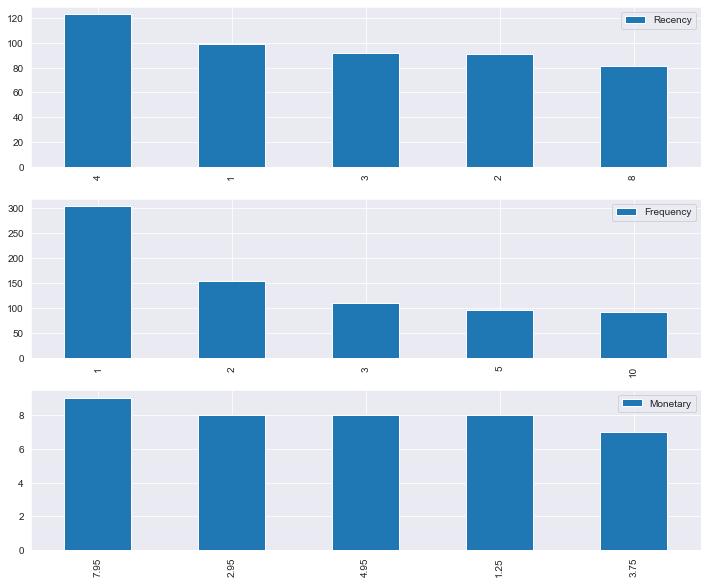

In [450]:
plt.figure(figsize=(12,10))
sns.set_style("darkgrid")
plt.subplot(3,1,1)
cust_rfm['Recency'].value_counts().iloc[:5].plot(kind = 'bar', legend = True, grid = True)
plt.subplot(3,1,2)
cust_rfm['Frequency'].value_counts().iloc[:5].plot(kind = 'bar', legend = True, grid = True)
plt.subplot(3,1,3)
cust_rfm['Monetary'].value_counts().iloc[:5].plot(kind = 'bar', legend = True, grid = True) # not very useful
plt.show()

The final RFM score is calculated using a weighted average of the three values R, F and M.\
The weights are distributed as follows : M = 0.4 ; F = 0.35 ; R = 0.25

Since this business deals mostly with wholesale purchasers, the amount spent is considered to be the most important factor. The number of products purchased is the next important factor and lastly the recency of purchase.

In [451]:
def weighted_score(score, weights): #R,F,M
    return sum(list(map(lambda x : x[0]*x[1], list(zip(score, weights))))) / (sum(weights))

RFM_Avg : Normal average of the three RFM scores.\
RFM_Combined : The concatenation of the three RFM scores.\
RFM_Modified : Weighted average of the RFM scores.

In [452]:
cust_rfm['RFM_Avg'] = cust_rfm[['Recency_Score', 'Frequency_Score', 'Monetary_Score']].sum(axis = 1) / 3
cust_rfm['RFM_Combined'] = cust_rfm[['Recency_Score', 'Frequency_Score', 'Monetary_Score']].apply(lambda x : int(str(x[0]) + str(x[1]) + str(x[2])), axis = 1)
cust_rfm['RFM_Modified'] = cust_rfm[['Recency_Score', 'Frequency_Score', 'Monetary_Score']].apply(weighted_score, weights = [0.25, 0.35, 0.4], axis = 1)

In [453]:
cust_rfm['RFM_Modified'].nunique()

81

In [454]:
cust_rfm['RFM_Avg'].value_counts()

2.333333    561
3.666667    546
3.333333    515
2.666667    491
3.000000    473
2.000000    455
4.000000    449
1.666667    445
4.333333    384
5.000000    377
1.333333    368
4.666667    365
1.000000    337
Name: RFM_Avg, dtype: int64

In [455]:
cust_rfm['RFM_Modified'].nunique()

81

In [456]:
cust_rfm['RFM_Combined'].nunique()

113

In [457]:
cust_rfm[['RFM_Combined', 'RFM_Modified']].drop_duplicates().sort_values('RFM_Modified', ascending = False).head()

,RFM_Combined,RFM_Modified
CustomerID,,
12347.0,555,5.00
12395.0,455,4.75
12388.0,545,4.65
12877.0,554,4.60
12359.0,355,4.50


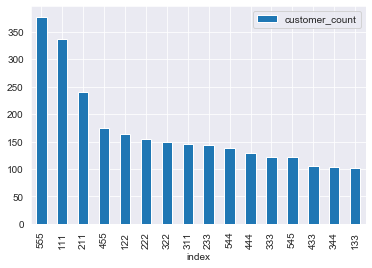

In [458]:
cust_rfm['RFM_Combined'].value_counts().reset_index(name = 'customer_count').query("customer_count > 100").set_index('index').plot(kind = 'bar')
plt.show()
# 3 out of our top 5 segments perform very well. However the poorest segment comes second with 272 customers.

In [459]:
cust_rfm['RFM_Avg'].value_counts().sort_index(ascending = False)

5.000000    377
4.666667    365
4.333333    384
4.000000    449
3.666667    546
3.333333    515
3.000000    473
2.666667    491
2.333333    561
2.000000    455
1.666667    445
1.333333    368
1.000000    337
Name: RFM_Avg, dtype: int64

### RFM Segmentation :-
Using the RFM scores, the customers are segmented into groups using the KMeans clustering algorithm.\
Each cluster will have customers with similar behaviour and thus can be targetted separately.

In [460]:
cust_rfm.describe()

,First_Purchase,Tenure,Recency,Frequency,Monetary,RFM_Avg,RFM_Combined,RFM_Modified
count,5766.000000,5766.000000,5766.000000,5766.000000,5766.000000,5766.000000,5766.000000,5766.000000
mean,215.891953,98.141866,117.506937,91.936178,1849.927947,2.997514,334.052376,2.996124
std,116.575700,127.620907,111.299279,209.864590,7919.026861,1.168659,148.705340,1.195744
min,1.000000,0.000000,1.000000,1.000000,0.420000,1.000000,111.000000,1.000000
25%,108.250000,0.000000,23.000000,14.000000,240.775000,2.000000,213.000000,2.000000
50%,237.000000,0.000000,72.000000,40.000000,632.475000,3.000000,333.000000,3.000000
75%,318.000000,204.000000,199.000000,105.000000,1642.825000,4.000000,453.000000,4.000000
max,374.000000,373.000000,374.000000,7847.000000,280206.020000,5.000000,555.000000,5.000000


###### KMeans : Assumptions to Satisfy
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;    1. Symmetric distribution of variables (Remove Skew)\
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; 2. Variables should have similar mean and variance

Plotting the distribution of the variables, we see that all of the variables are skewed to the right, which shifts the mean towards the left.

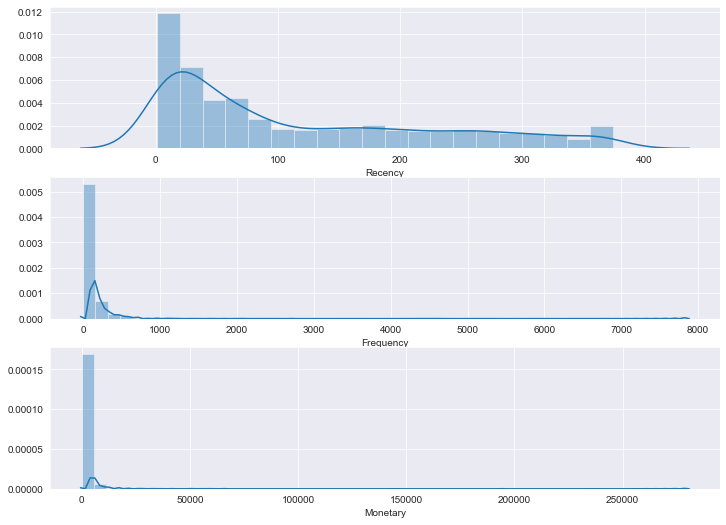

In [461]:
#RFM Distribution :-

plt.figure(figsize = (12,12))
sns.set_style("darkgrid")
plt.subplot(4,1,1)
sns.distplot(cust_rfm['Recency'])
plt.subplot(4,1,2)
sns.distplot(cust_rfm['Frequency'])
plt.subplot(4,1,3)
sns.distplot(cust_rfm['Monetary'])
plt.show()

The skewness of the distribution can be removed by applying some transformation function. Here we apply a very simple transformation function called the 'log transformation'.\
Since log 0 is not defined, we add a small value 0.001 to all the elements. This makes the transformation possible and unbiased

In [462]:
cluster_rfm = cust_rfm[['Recency', 'Frequency', 'Monetary', 'First_Purchase']] + 0.001
cluster_rfm_log = cluster_rfm.apply(np.log) 

In [463]:
cluster_rfm_log.describe().round(2)

,Recency,Frequency,Monetary,First_Purchase
count,5766.00,5766.00,5766.00,5766.00
mean,4.06,3.53,6.27,5.09
std,1.44,1.56,1.75,0.94
min,0.00,0.00,-0.87,0.00
25%,3.14,2.64,5.48,4.68
50%,4.28,3.69,6.45,5.47
75%,5.29,4.65,7.40,5.76
max,5.92,8.97,12.54,5.92


The disribution after transformation is shown below. We see that the data is no more skewed

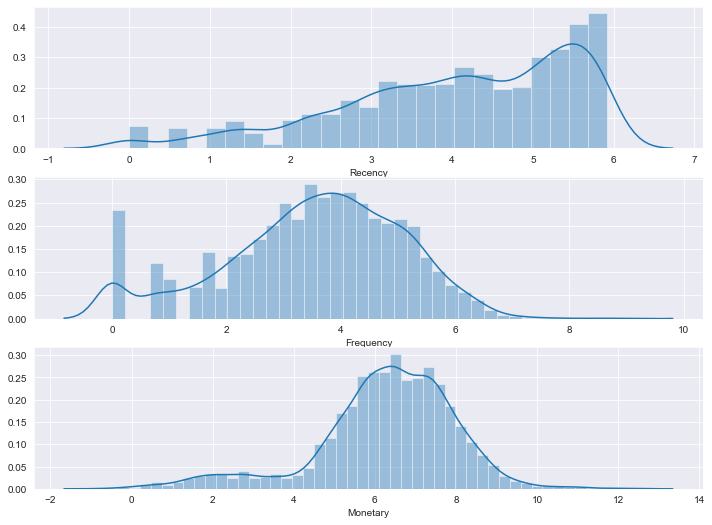

In [464]:
#RFM distribution after transformation:-

plt.figure(figsize = (12,12))
sns.set_style("darkgrid")
plt.subplot(4,1,1)
sns.distplot(cluster_rfm_log['Recency'])
plt.subplot(4,1,2)
sns.distplot(cluster_rfm_log['Frequency'])
plt.subplot(4,1,3)
sns.distplot(cluster_rfm_log['Monetary'])
plt.show()

To satisfy the next assumption we need all the variables to be in the same scale and thus have a similar mean and variance.\
But we see below that the data is not in similar scale.\
So we standardize each variable by subtracting from the mean and dividing by the standard deviation.

In [465]:
cluster_rfm.describe().round(2)

,Recency,Frequency,Monetary,First_Purchase
count,5766.00,5766.00,5766.00,5766.00
mean,117.51,91.94,1849.93,215.89
std,111.30,209.86,7919.03,116.58
min,1.00,1.00,0.42,1.00
25%,23.00,14.00,240.78,108.25
50%,72.00,40.00,632.48,237.00
75%,199.00,105.00,1642.83,318.00
max,374.00,7847.00,280206.02,374.00


In [466]:
Scaler = preprocessing.StandardScaler()
Scaler.fit(cluster_rfm_log)
cluster_rfm_trans = pd.DataFrame(Scaler.transform(cluster_rfm_log))

After standardisation, our data now satisfies our assumption.

In [467]:
cluster_rfm_trans.describe().round(2)

,0,1,2,3
count,5766.00,5766.00,5766.00,5766.00
mean,-0.00,-0.00,-0.00,-0.00
std,1.00,1.00,1.00,1.00
min,-2.82,-2.27,-4.07,-5.40
25%,-0.64,-0.57,-0.45,-0.43
50%,0.15,0.10,0.11,0.40
75%,0.86,0.72,0.65,0.71
max,1.30,3.49,3.59,0.88


To decide on the number of clusters (value of k), we use the elbow method to find clusters for different values of k and plot the sum of squares of error. 

In [468]:
sse = []
for k in range(1,10):
    kmeans_result = KMeans(n_clusters = k, n_init = 50, max_iter = 500, random_state = 4).fit(cluster_rfm_trans)
    sse.append(kmeans_result.inertia_)

In [469]:
sse

[23064.0,
 15565.610576631381,
 11552.933945539062,
 8801.765043917072,
 7518.726170803472,
 6675.898486406573,
 6072.280684193243,
 5512.061870270065,
 5098.479200741763]

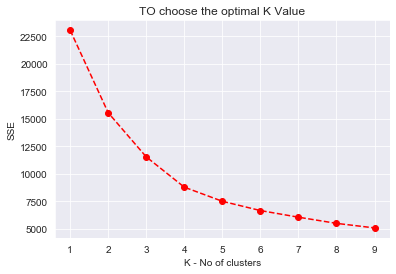

In [470]:
sns.set_style("darkgrid")
plt.plot(range(1,10), sse, 'ro', linestyle = '--')
plt.title('TO choose the optimal K Value')
plt.xlabel('K - No of clusters')
plt.ylabel('SSE')
plt.show()

Based on the observation we choose k = 4 as the optimal number of clusters.

In [471]:
rmf_clusters = KMeans(n_clusters = 4, n_init = 100, max_iter = 1000, random_state = 4).fit(cluster_rfm_trans)
cluster_rfm['Cluster'] = rmf_clusters.labels_ + 1
cluster_rfm.head()

,Recency,Frequency,Monetary,First_Purchase,Cluster
CustomerID,,,,,
12346.0,326.001,1.001,77183.601,326.001,2
12347.0,2.001,182.001,4310.001,367.001,1
12348.0,75.001,31.001,1797.241,358.001,2
12349.0,19.001,73.001,1757.551,19.001,4
12350.0,310.001,17.001,334.401,310.001,2


We see the basic statistics associated with each cluster below and we interpret the clusters

In [472]:
rfm_cluster_stats = cluster_rfm.groupby('Cluster').aggregate({'Recency' : {np.median, np.max, np.mean, np.std},
                                          'Frequency' : {np.median, np.max, np.mean, np.std},
                                          'Monetary' : {np.median, np.max, np.mean, np.std},
                                          'First_Purchase' : {np.median, np.max, np.mean, np.std, 'count'}
                                         }).round(0)

In [473]:
cluster_mean = cluster_rfm.groupby('Cluster').aggregate(np.mean)
cluster_mean

,Recency,Frequency,Monetary,First_Purchase
Cluster,,,,
1,17.784843,209.402019,4983.405381,290.372907
2,174.874371,70.939925,1116.148025,246.258736
3,211.434628,4.287504,92.845878,217.713389
4,31.478713,62.293636,963.468113,42.870186


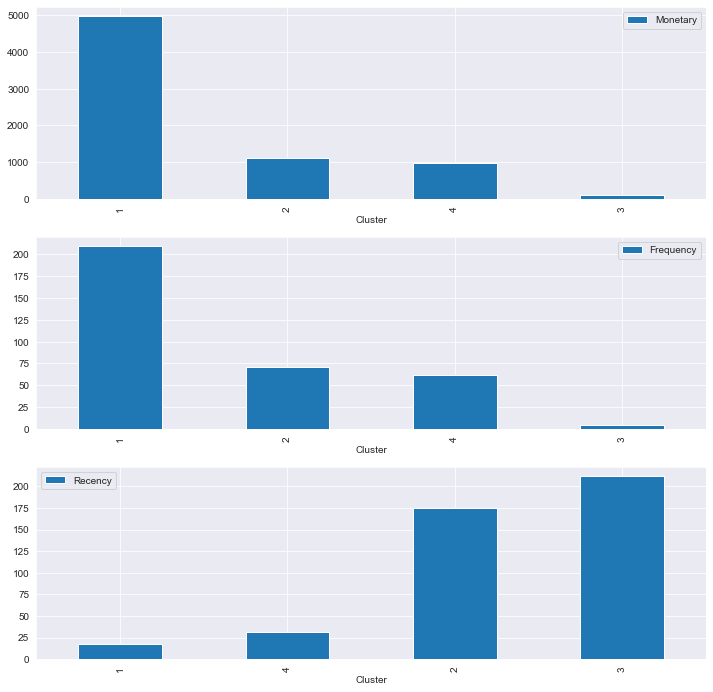

In [474]:
plt.figure(figsize = (12,12))
sns.set_style("darkgrid")
plt.subplot(3,1,1)
cluster_mean['Monetary'].sort_values(ascending = False).plot(kind = 'bar', label = 'Monetary')
plt.legend()
plt.subplot(3,1,2)
cluster_mean['Frequency'].sort_values(ascending = False).plot(kind = 'bar', label = 'Frequency')
plt.legend()
plt.subplot(3,1,3)
cluster_mean['Recency'].sort_values(ascending = True).plot(kind = 'bar', label = 'Recency')
plt.legend()

plt.show()

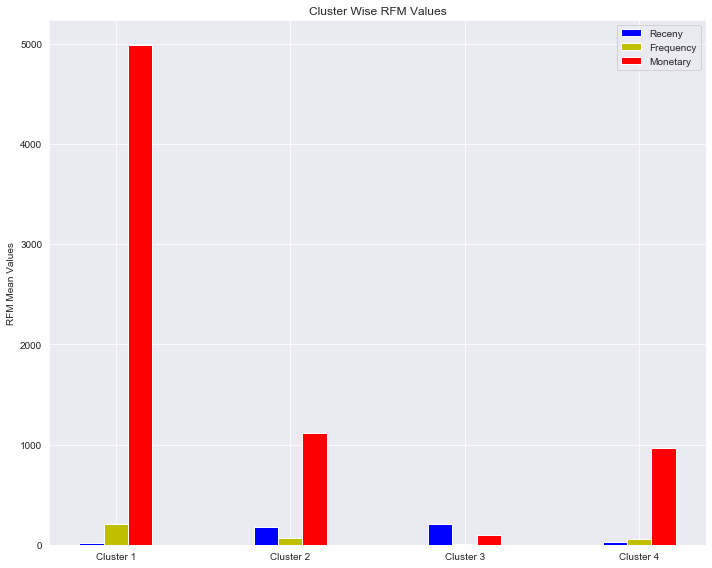

In [475]:
x = np.array([5, 10, 15, 20])
width = 0.7

r = cluster_mean['Recency'].values
f = cluster_mean['Frequency'].values
m = cluster_mean['Monetary'].values

sns.set_style("darkgrid")
plt.figure(figsize=(10,8))

ax = plt.subplot(111)
ax.bar(x, r, width, color='b', align='center')
ax.bar(x+width, f, width, color='y', align='center')
ax.bar(x+(width*2), m, width, color='r', align='center')

ax.set_ylabel('RFM Mean Values')
ax.set_xticks(x+width)
ax.set_xticklabels(['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'])
plt.title('Cluster Wise RFM Values')
ax.legend(('Receny', 'Frequency', 'Monetary'))

plt.tight_layout()
plt.show()

From the table and the figure shown above, we arrive at the following conclusions about the clusters :

**Cluster 1** : Has the 'highest' mean monetary value, 'highest' mean frequency and the 'least' mean recency. These are the ideal values for each of the variables and thus is the cluster containing the best customers. From the mean of the first purchase variable it is also seen that these customers have been assoiated with the business for a very long time. We shall call this cluster as our "VIP customer cluster".

**Cluster 2** : Has the 'second highest' mean monetary value and frequency and the 'third' mean recency. This cluster also contains customers who have been for a long time. These customers have a great potential to enter the VIP cluster provided that they purchase more often, increasing their recency metric. We call this cluster as our "Potetial customer cluster".

**Cluster 4** : Has the 'third highest' mean monetary value and frequency and the 'second' mean recency. The mean first purchase is very low whoch indeicates that these customer have started purchasing only recently. We can give some promotions and nudges to enable them to continue shopping with us. We call this cluster as our "New Customer cluster".

**Cluster 3** : Has the 'least' mean monetary and frequency value and the 'highest' mean recency. These are the poorest values for each of the variables. It is also seen that the mean first purchase is quite close to the mean recency which mean that they have not purchased for a very long time. We call this cluster as our "At Risk customer cluster".

#### Cluster Visualisation

In [476]:
from sklearn.decomposition import PCA
pca_model = PCA(n_components = 2).fit(cluster_rfm_trans)
pca_2d = pca_model.transform(cluster_rfm_trans)

In [477]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(cluster_rfm['Cluster'])

In [478]:
cluster_viz_data = cluster_rfm_trans.copy()
cluster_viz_data['Cluster'] = cluster_rfm.reset_index()['Cluster']
cluster_viz_data.head()

,0,1,2,3,Cluster
0,1.201564,-2.265973,2.850819,0.736273,2
1,-2.341419,1.072909,1.202066,0.861997,1
2,0.179416,-0.062932,0.702234,0.835647,2
3,-0.775681,0.486672,0.689473,-2.280342,4
4,1.166557,-0.448444,-0.258741,0.682863,2


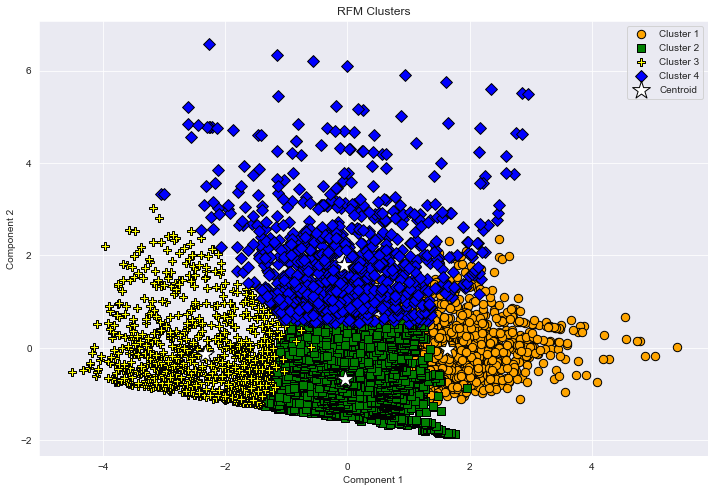

In [481]:
plt.figure(figsize = (12,8))
sns.set_style("darkgrid")
plt.scatter(pca_2d[cluster_viz_data.Cluster == 1, 0], pca_2d[cluster_viz_data.Cluster == 1, 1],
            s=70, c='orange', marker='o', edgecolor='black', label='Cluster 1')

plt.scatter(pca_2d[cluster_viz_data.Cluster == 2, 0], pca_2d[cluster_viz_data.Cluster == 2, 1],
            s=70, c='green', marker='s', edgecolor='black',label='Cluster 2')

plt.scatter(pca_2d[cluster_viz_data.Cluster == 3, 0], pca_2d[cluster_viz_data.Cluster == 3, 1],
            s=70, c='yellow',marker='P', edgecolor='black',label='Cluster 3')

plt.scatter(pca_2d[cluster_viz_data.Cluster == 4, 0], pca_2d[cluster_viz_data.Cluster == 4, 1],
            s=70, c='blue',marker='D', edgecolor='black',label='Cluster 4')

centroids = pca_model.transform(rmf_clusters.cluster_centers_)

plt.scatter(centroids[:,0], centroids[:,1], s=350, marker='*', c='white', edgecolor='black', label='Centroid')

plt.title('RFM Clusters')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend()
plt.show()